In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats.mstats import winsorize
from scipy.stats import skew
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from feature_engine.selection import RecursiveFeatureAddition
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
import shap

I am utilizing this code as guidance, https://github.com/inab-certh/Predicting-COVID-19-severity-through-interpretable-AI-analysis-of-plasma-proteomics/blob/main/Task%202.ipynb

## Reading in ISB and ICL Data

In [7]:
isb_clinical = pd.read_excel('final_data/ISB/isb_clinical.xlsx')
isb_proteomics = pd.read_excel('final_data/ISB/isb_proteomics.xlsx')
isb_metabolomics = pd.read_excel('final_data/ISB/isb_metabolomics.xlsx')

In [3]:
isb_clinical.columns

Index(['subject_id', 'blood_draw', 'observation_days_since_enrollment',
       'onset_of_symptoms_days_before_enrollment',
       'observation_days_since_onset_of_symptoms', 'encounter_location',
       'who_severity', 'mechanical_ventilation', 'respiratory_support',
       'systolic_bp', 'diastolic_bp', 'temperature', 'pulse',
       'blood_oxygenation', 'chest_xray_ct', 'bmi_at_baseline', 'sex', 'age',
       'ethnicity', 'race', 'ace_inhibitor',
       'angiotensin_ii_receptor_blockers', 'asthma', 'cancer',
       'chronic_hypertension', 'cigarette_smoking', 'kidney_disease',
       'congestive_heart_failure', 'copd', 'coronary_artery_disease',
       'new_column5', 'hiv', 'immunocompromised', 'immunosuppressant', '10x',
       'metabolomics', 'proteomics', 'isoplexis_cd8_assay',
       'isoplexis_cd4_assay', 'isoplexis_monocyte_assay', 'isoplexis_nk_assay',
       'sars-cov-2_antibody_assay', 'autoantibody_\nassay',
       'sara-cov-2_rnaemia_assay', 'sara-cov-2_nasal_swab_assay',


**Removing Ethnicity**

In [4]:
isb_clinical.drop('ethnicity', axis=1, inplace=True)

Matching **sample ids** for ICL Wave 1

In [5]:
isb_proteomics.set_index('subject_id', inplace=True)
isb_metabolomics.set_index('subject_id', inplace=True)
isb_clinical.set_index('subject_id', inplace=True)

## Checking for Missing Values

In [6]:
pro_rows_with_na = isb_proteomics.isna().any(axis=1)

print("Number of rows with at least one missing value:")
print("ISB Proteomics: ", pro_rows_with_na.sum())

Number of rows with at least one missing value:
ISB Proteomics:  0


In [7]:
met_rows_with_na = isb_metabolomics.isna().any(axis=1)

print("Number of rows with at least one missing value:")
print("ISB Metabolomics: ", met_rows_with_na.sum())

Number of rows with at least one missing value:
ISB Metabolomics:  0


In [8]:
relevant_clinical_columns = ['who_severity', 'sex', 'age', 'cigarette_smoking', 'kidney_disease', 
                            'chronic_hypertension', 'cancer', 'asthma', 'copd', 'coronary_artery_disease', 
                            'respiratory_support']

isb_clinical = isb_clinical[relevant_clinical_columns]
isb_clinical

,who_severity,sex,age,cigarette_smoking,kidney_disease,chronic_hypertension,cancer,asthma,copd,coronary_artery_disease,respiratory_support
subject_id,,,,,,,,,,,
INCOV001,3,Female,77,Never,No,Yes,No,No,No,No,None
INCOV002,5,Male,39,Unknown,No,No,No,No,No,No,High flow nasal cannula (HFNC)
INCOV003,7,Male,64,Never,Yes,Yes,No,No,No,No,Other
INCOV004,4,Male,76,Former,No,No,Yes,No,Yes,Yes,Nasal cannula
INCOV005,4,Male,75,Former,No,Yes,No,No,Yes,No,Nasal cannula
...,...,...,...,...,...,...,...,...,...,...,...
INCOV198,6,Female,40,Never,No,No,No,Yes,No,No,Other
INCOV199,7,Male,57,Never,No,No,No,No,No,No,Other
INCOV200,7,Male,51,Never,No,Yes,No,No,No,No,Other


In [9]:
clin_rows_with_na = isb_clinical.isna().any(axis=1)

print("Number of rows with at least one missing value:")
print("ISB Clinical: ", clin_rows_with_na.sum())

Number of rows with at least one missing value:
ISB Clinical:  0


## Binning Age

In [10]:
isb_clinical['age']

subject_id
INCOV001    77
INCOV002    39
INCOV003    64
INCOV004    76
INCOV005    75
            ..
INCOV198    40
INCOV199    57
INCOV200    51
INCOV201    50
INCOV202    60
Name: age, Length: 198, dtype: int64

In [11]:
isb_clinical['age'].describe()

count    198.000000
mean      56.176768
std       17.700958
min       18.000000
25%       41.250000
50%       57.000000
75%       69.750000
max       89.000000
Name: age, dtype: float64

Categorizing ages as follows:
- ages 0 to 40
- ages 41 to 60
- ages 61 to 80
- ages 81 and above

In [12]:
age_bins = [0, 40, 60, 80, 100]
age_labels = [0, 1, 2, 3] 

isb_clinical['age'] = pd.cut(isb_clinical['age'], bins=age_bins, labels=age_labels, right=True).astype(int)

print("ISB Data:")
print(isb_clinical['age'].value_counts())

ISB Data:
1    66
2    65
0    46
3    21
Name: age, dtype: int64


## Modifying Target

In [13]:
def target_recode_scale(value):
    if value in [1, 2, 3, '1 or 2']:
        return 'mild'
    elif value in [4, 5]:
        return 'moderate'
    elif value in [6, 7]:
        return 'severe'

isb_clinical['who_severity'] = isb_clinical['who_severity'].apply(target_recode_scale)

In [14]:
isb_clinical['who_severity'].value_counts()

mild        93
moderate    76
severe      29
Name: who_severity, dtype: int64

## Splitting Data

In [15]:
y = isb_clinical['who_severity']

label_order = {'mild': 0, 'moderate': 1, 'severe': 2}

y = y.map(label_order)

print("Target:")
y.value_counts()

Target:


0    93
1    76
2    29
Name: who_severity, dtype: int64

In [16]:
y.value_counts()

0    93
1    76
2    29
Name: who_severity, dtype: int64

In [17]:
from sklearn.model_selection import train_test_split

isb_proteomics_mod = isb_proteomics.drop(['Blood Draw', 'Healthy or INCOV', 'age', 'sex', 'BMI'], axis = 1)
isb_metabolomics_mod = isb_metabolomics.drop(['Blood Draw', 'Healthy or INCOV', 'age', 'sex', 'BMI'], axis = 1)
isb_clinical_mod = isb_clinical.drop(['who_severity'], axis = 1)

X_metabolomic_temp, X_metabolomic_test, y_metabolomic_temp, y_metabolomic_test = train_test_split(isb_metabolomics_mod, y, test_size=0.2, random_state=42, stratify=y)
X_proteomic_temp, X_proteomic_test, y_proteomic_temp, y_proteomic_test = train_test_split(isb_proteomics_mod, y, test_size=0.2, random_state=42, stratify=y)
X_clinical_temp, X_clinical_test, y_clinical_temp, y_clinical_test = train_test_split(isb_clinical_mod, y, test_size=0.2, random_state=42, stratify=y)

X_metabolomic_train, X_metabolomic_val, y_metabolomic_train, y_metabolomic_val = train_test_split(X_metabolomic_temp, y_metabolomic_temp, test_size=0.5, random_state=42, stratify=y_metabolomic_temp)
X_proteomic_train, X_proteomic_val, y_proteomic_train, y_proteomic_val = train_test_split(X_proteomic_temp, y_proteomic_temp, test_size=0.5, random_state=42, stratify=y_proteomic_temp)
X_clinical_train, X_clinical_val, y_clinical_train, y_clinical_val = train_test_split(X_clinical_temp, y_clinical_temp, test_size=0.5, random_state=42, stratify=y_clinical_temp)

In [117]:
print("Proteomics Train Target:", y_proteomic_train.value_counts(normalize=True))  

print("Proteomics Test Target:", y_proteomic_test.value_counts(normalize=True))

print("Proteomics Val Target:",y_proteomic_val.value_counts(normalize=True))  

Proteomics Train Target: 0    0.468354
1    0.379747
2    0.151899
Name: who_severity, dtype: float64
Proteomics Test Target: 0    0.475
1    0.375
2    0.150
Name: who_severity, dtype: float64
Proteomics Val Target: 0    0.468354
1    0.392405
2    0.139241
Name: who_severity, dtype: float64


In [23]:
X_clinical_train = X_clinical_train.copy()
X_clinical_test = X_clinical_test.copy()
X_clinical_val = X_clinical_val.copy()

## Encoding Clinical Features

Addressing the unknown value in some clinical features

In [24]:
def replace_unknown_with_mode(train_column, test_column):
    mode_value = train_column.mode()[0]
    return train_column.replace('Unknown', mode_value), test_column.replace('Unknown', mode_value)

In [26]:
isb_clinical['cancer'].value_counts()

No         174
Yes         23
Unknown      1
Name: cancer, dtype: int64

In [27]:
X_clinical_train['cancer'], X_clinical_test['cancer'] = replace_unknown_with_mode(X_clinical_train['cancer'], X_clinical_test['cancer'])
X_clinical_train['cancer'], X_clinical_val['cancer'] = replace_unknown_with_mode(X_clinical_train['cancer'], X_clinical_val['cancer'])

In [25]:
X_clinical_train['cigarette_smoking'], X_clinical_test['cigarette_smoking'] = replace_unknown_with_mode(X_clinical_train['cigarette_smoking'], X_clinical_test['cigarette_smoking'])
X_clinical_train['cigarette_smoking'], X_clinical_val['cigarette_smoking'] = replace_unknown_with_mode(X_clinical_train['cigarette_smoking'], X_clinical_val['cigarette_smoking'])

In [29]:
X_clinical_train['asthma'], X_clinical_test['asthma'] = replace_unknown_with_mode(X_clinical_train['asthma'], X_clinical_test['asthma'])
X_clinical_train['asthma'], X_clinical_val['asthma'] = replace_unknown_with_mode(X_clinical_train['asthma'], X_clinical_val['asthma'])

In [30]:
X_clinical_train['copd'], X_clinical_test['copd'] = replace_unknown_with_mode(X_clinical_train['copd'], X_clinical_test['copd'])
X_clinical_train['copd'], X_clinical_val['copd'] = replace_unknown_with_mode(X_clinical_train['copd'], X_clinical_val['copd'])

In [31]:
X_clinical_train['coronary_artery_disease'], X_clinical_test['coronary_artery_disease'] = replace_unknown_with_mode(X_clinical_train['coronary_artery_disease'], X_clinical_test['coronary_artery_disease'])
X_clinical_train['coronary_artery_disease'], X_clinical_val['coronary_artery_disease'] = replace_unknown_with_mode(X_clinical_train['coronary_artery_disease'], X_clinical_val['coronary_artery_disease'])

In [32]:
cigarette_ordering = [['Never', 'Former', 'Current']]
respiratory_support_ordering = [['None', 'Other', 'Nasal cannula', 'High flow nasal cannula (HFNC)']]

In [33]:
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

encoder = OrdinalEncoder(categories=cigarette_ordering)

X_clinical_train['cigarette_smoking'] = encoder.fit_transform(X_clinical_train[['cigarette_smoking']]).astype(int)

X_clinical_val['cigarette_smoking'] = encoder.transform(X_clinical_val[['cigarette_smoking']]).astype(int)
X_clinical_test['cigarette_smoking'] = encoder.transform(X_clinical_test[['cigarette_smoking']]).astype(int)

encoder_respiratory_support = OrdinalEncoder(categories=respiratory_support_ordering)

X_clinical_train['respiratory_support'] = encoder_respiratory_support.fit_transform(X_clinical_train[['respiratory_support']]).astype(int)
X_clinical_val['respiratory_support'] = encoder_respiratory_support.transform(X_clinical_val[['respiratory_support']]).astype(int)
X_clinical_test['respiratory_support'] = encoder_respiratory_support.transform(X_clinical_test[['respiratory_support']]).astype(int)

age_train = X_clinical_train.pop('age')
age_val = X_clinical_val.pop('age')
age_test = X_clinical_test.pop('age')

binary_columns = ['sex', 'kidney_disease', 'chronic_hypertension', 'cancer', 'asthma', 'copd', 'coronary_artery_disease']
binary_mapping = {'Male': 1, 'Yes': 1, 'Female': 0, 'No': 0}

for column in binary_columns:
    X_clinical_train[column] = X_clinical_train[column].map(binary_mapping)
    X_clinical_val[column] = X_clinical_val[column].map(binary_mapping)
    X_clinical_test[column] = X_clinical_test[column].map(binary_mapping)

X_clinical_train['age'] = age_train


X_clinical_val['age'] = age_val


X_clinical_test['age'] = age_test

In [34]:
X_clinical_train

,sex,cigarette_smoking,kidney_disease,chronic_hypertension,cancer,asthma,copd,coronary_artery_disease,respiratory_support,age
subject_id,,,,,,,,,,
INCOV082,0,0,0,0,0,1,0,0,0,1
INCOV076,0,0,0,0,0,0,0,0,0,1
INCOV176,0,0,0,1,0,0,0,0,0,2
INCOV161,1,0,1,1,0,0,0,0,3,1
INCOV104,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
INCOV135,0,0,0,0,0,0,0,0,0,1
INCOV179,1,0,0,1,0,0,0,1,2,2
INCOV070,1,0,0,0,0,0,0,0,1,1


## Checking Correlation and Multicollinearity

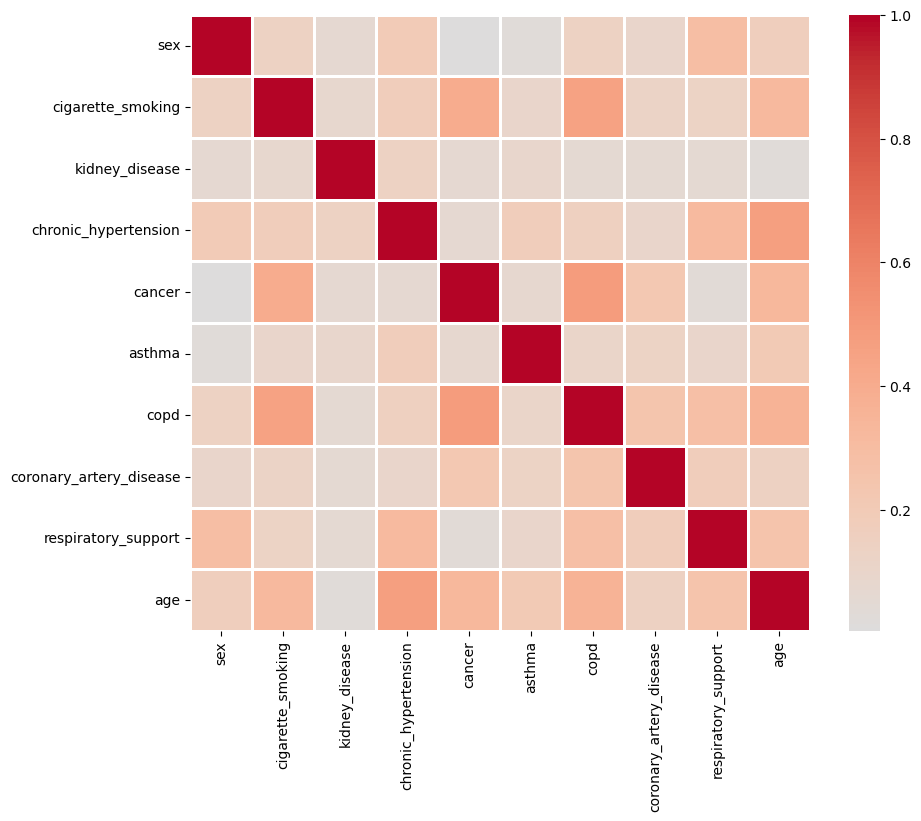

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = X_clinical_train.corr().abs()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, linewidths=1, annot=False, fmt=".2f")
plt.show()

In [36]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

df_const = add_constant(X_clinical_test)

vif_data = pd.DataFrame()
vif_data["Variable"] = df_const.columns
vif_data["VIF"] = [variance_inflation_factor(df_const.values, i) for i in range(df_const.shape[1])]

print(vif_data)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Omics Preprocessing Pipeline

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

proteomics_scaling_selection = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('selector', RFE(estimator=LogisticRegression(), n_features_to_select=100))
])

metabolomics_scaling_selection = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('selector', RFE(estimator=LogisticRegression(), n_features_to_select=100))
])

### Proteomics

In [38]:
X_proteomic_train_preprocessed = proteomics_scaling_selection.fit_transform(X_proteomic_train, y_proteomic_train)

X_proteomic_val_preprocessed = proteomics_scaling_selection.transform(X_proteomic_val)
X_proteomic_test_preprocessed = proteomics_scaling_selection.transform(X_proteomic_test)

selected_features_proteomics = X_proteomic_train.columns[proteomics_scaling_selection.named_steps['selector'].support_]

X_proteomic_train_preprocessed = pd.DataFrame(X_proteomic_train_preprocessed, columns=selected_features_proteomics, index=X_proteomic_train.index)
X_proteomic_val_preprocessed = pd.DataFrame(X_proteomic_val_preprocessed, columns=selected_features_proteomics, index=X_proteomic_val.index)
X_proteomic_test_preprocessed = pd.DataFrame(X_proteomic_test_preprocessed, columns=selected_features_proteomics, index=X_proteomic_test.index)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


### Metabolomics

In [39]:
X_metabolomic_train_preprocessed = metabolomics_scaling_selection.fit_transform(X_metabolomic_train, y_metabolomic_train)
X_metabolomic_val_preprocessed = metabolomics_scaling_selection.transform(X_metabolomic_val)
X_metabolomic_test_preprocessed = metabolomics_scaling_selection.transform(X_metabolomic_test)

selected_features_metabolomics = X_metabolomic_train.columns[metabolomics_scaling_selection.named_steps['selector'].support_]

X_metabolomic_train_preprocessed = pd.DataFrame(X_metabolomic_train_preprocessed, columns=selected_features_metabolomics, index=X_metabolomic_train.index)
X_metabolomic_val_preprocessed = pd.DataFrame(X_metabolomic_val_preprocessed, columns=selected_features_metabolomics, index=X_metabolomic_val.index)
X_metabolomic_test_preprocessed = pd.DataFrame(X_metabolomic_test_preprocessed, columns=selected_features_metabolomics, index=X_metabolomic_test.index)

## PCA

In [40]:
original_columns_proteomics = X_proteomic_train_preprocessed.columns.tolist()
original_columns_metabolomics = X_metabolomic_train_preprocessed.columns.tolist()

In [41]:
pca_proteomics = PCA(.90)
pca_metabolomics = PCA(.90)

### Transforming Proteomics Data

In [42]:
X_proteomic_train_preprocessed = pd.DataFrame(pca_proteomics.fit_transform(X_proteomic_train_preprocessed), index=X_proteomic_train_preprocessed.index)
X_proteomic_test_preprocessed = pd.DataFrame(pca_proteomics.transform(X_proteomic_test_preprocessed), index=X_proteomic_test_preprocessed.index)
X_proteomic_val_preprocessed = pd.DataFrame(pca_proteomics.transform(X_proteomic_val_preprocessed), index=X_proteomic_val_preprocessed.index)

loadings_proteomics = pca_proteomics.components_.T * np.sqrt(pca_proteomics.explained_variance_)

loading_matrix_proteomics= pd.DataFrame(loadings_proteomics, index=original_columns_proteomics)
loading_matrix_proteomics

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
O00220,0.882997,0.126665,0.150747,0.104458,0.138232,0.062426,-0.067393,0.082035,0.016597,-0.096012,...,-0.002042,-0.032891,-0.014902,-0.113535,0.076477,-0.029629,-0.000290,-0.042853,0.052117,0.087236
O43915,-0.253782,0.439444,0.314826,0.144513,-0.226913,0.114937,0.009128,-0.236650,-0.003119,-0.183556,...,-0.039474,-0.060428,-0.169909,0.014868,0.023983,-0.096225,-0.133698,-0.051461,0.220577,0.025138
P00797,0.488959,0.045322,-0.077890,-0.153677,0.014092,-0.248493,-0.006053,0.029604,0.261868,-0.319654,...,-0.058054,-0.008659,0.175377,-0.083726,0.101702,0.039359,0.037413,0.071952,-0.094901,-0.149029
P02760,-0.125959,0.436257,0.377309,0.073331,0.233136,0.100541,0.006259,0.212108,0.005550,-0.171106,...,-0.195874,0.017860,0.147596,-0.025151,0.000579,-0.034143,-0.006225,0.079179,-0.062006,0.167890
P05231,0.807057,-0.356117,0.122036,-0.128666,0.064841,-0.150841,-0.037185,-0.070349,0.079446,0.062009,...,-0.032605,0.047496,-0.057079,0.023377,-0.050017,0.012805,0.014168,0.019994,0.039507,0.046687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q0Z7S8,-0.083997,0.521831,0.292229,0.090809,-0.131906,-0.009282,-0.200600,0.148054,-0.263207,0.077114,...,-0.028008,0.042725,-0.098632,0.032921,-0.017685,-0.003118,-0.189178,-0.099879,-0.026254,0.032757
Q15116,0.174409,0.064170,0.082504,-0.069465,0.178003,-0.060541,-0.345947,-0.162222,0.444757,-0.113543,...,-0.223222,-0.010207,-0.247939,0.220349,0.070514,-0.041213,-0.067066,-0.159719,-0.120296,0.000746
Q9HAW4,0.389098,0.005759,-0.405694,0.135039,0.303501,0.260819,-0.062312,-0.068199,0.024795,-0.278564,...,-0.166960,0.021525,0.035624,0.076259,0.023848,-0.116308,-0.085665,-0.070124,-0.073889,-0.072736
Q9NXA8,-0.041237,0.046613,-0.395498,0.147603,0.276991,0.163191,-0.290075,0.260191,0.154750,-0.151281,...,0.067411,0.100095,-0.091804,0.094723,-0.029146,0.054754,0.158845,0.170650,-0.032585,-0.140142


In [43]:
load_trans_proteomics = loading_matrix_proteomics.T
loading_pow_proteomics = {}


for i in load_trans_proteomics.columns:
    magnitude = load_trans_proteomics[i].pow(2).sum()
    loading_pow_proteomics[i] = magnitude

pd.DataFrame.from_dict(loading_pow_proteomics, orient='index').to_excel('loadingspowProteomics.xlsx')

### Transforming Metabolomics Data

In [44]:
X_metabolomic_train_preprocessed = pd.DataFrame(pca_metabolomics.fit_transform(X_metabolomic_train_preprocessed), index=X_metabolomic_train_preprocessed.index)
X_metabolomic_test_preprocessed = pd.DataFrame(pca_metabolomics.transform(X_metabolomic_test_preprocessed), index=X_metabolomic_test_preprocessed.index)
X_metabolomic_val_preprocessed = pd.DataFrame(pca_metabolomics.transform(X_metabolomic_val_preprocessed), index=X_metabolomic_val_preprocessed.index)

loadings_metabolomics = pca_metabolomics.components_.T * np.sqrt(pca_metabolomics.explained_variance_)

loading_matrix_metabolomics = pd.DataFrame(loadings_metabolomics, index=original_columns_metabolomics)
loading_matrix_metabolomics

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
"N6,N6,N6-trimethyllysine",0.470513,0.548651,-0.225668,0.094632,-0.196843,-0.034190,-0.002322,-0.124521,0.067830,-0.065114,...,0.110565,-0.088661,0.088962,-0.130672,0.094340,0.088028,0.133583,-0.036720,0.069779,0.125704
5-methylthioadenosine (MTA),0.453972,0.537993,-0.316116,0.052313,-0.201374,-0.067715,0.189172,-0.132486,0.254219,0.015649,...,0.090271,0.057962,0.017464,-0.115300,0.029773,-0.137066,-0.036506,0.040367,-0.054671,0.053160
3-(4-hydroxyphenyl)lactate,0.417745,0.519686,0.075200,0.243198,-0.160703,-0.106047,-0.104164,-0.076001,0.054291,-0.146621,...,-0.027753,0.035863,-0.023710,-0.144763,-0.069241,0.046219,-0.094894,-0.044898,0.090657,-0.119872
cystine,0.149542,-0.073561,-0.096912,-0.079504,-0.101648,0.204095,0.410214,-0.227127,0.370749,-0.021913,...,0.048887,0.042223,-0.009010,-0.042676,-0.008950,-0.066095,0.025424,0.094948,0.120496,0.035162
guanidinoacetate,-0.623980,-0.150471,-0.098516,0.159388,-0.190788,0.101375,-0.038147,-0.111961,0.122083,-0.117186,...,0.010404,0.070827,-0.070015,0.134317,0.046428,-0.098242,0.040269,-0.032021,0.124991,0.102071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X - 12100,0.625873,0.552103,0.009296,0.016823,0.169590,-0.094697,0.178492,0.009226,0.124715,-0.149808,...,-0.018853,-0.033596,0.016719,-0.075181,-0.017898,0.103372,-0.026821,0.012491,0.070456,0.109249
X - 17010,0.378184,0.214634,0.284497,0.032439,-0.194853,0.164299,0.035727,-0.045867,0.154165,0.204759,...,0.121935,-0.124451,0.123691,0.158777,0.198060,-0.149481,-0.123472,0.007696,-0.186505,-0.117844
X - 23641,0.450556,0.552923,-0.254602,0.090381,0.058640,-0.049585,0.144037,-0.012675,0.109012,0.071553,...,-0.027094,-0.036008,0.146358,0.113417,-0.170875,0.051918,-0.082410,-0.113763,-0.001791,-0.120637
X - 24549,-0.287841,0.241289,-0.155995,-0.071122,0.127506,0.159907,-0.263614,-0.253474,-0.275369,-0.166886,...,-0.137416,-0.050767,0.186847,0.079609,0.054259,-0.031307,-0.016521,0.174595,0.171191,-0.119673


In [45]:
load_trans_metabolomics = loading_matrix_metabolomics.T
loading_pow_metabolomics = {}


for i in load_trans_metabolomics.columns:
    magnitude = load_trans_metabolomics[i].pow(2).sum()
    loading_pow_metabolomics[i] = magnitude

pd.DataFrame.from_dict(loading_pow_metabolomics, orient='index').to_excel('loadingspowMetabolomics.xlsx')

## Model Training

In [63]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from numpy import mean
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

models = {
    'logistic_regression': LogisticRegression(),
    'decision_tree': DecisionTreeClassifier(),
    'rand_forest': RandomForestClassifier(),
    'extra_trees': ExtraTreesClassifier(),
    'mlp': MLPClassifier(),
    'svm': SVC(),
    'ada_boost': AdaBoostClassifier(),
    'xgb': xgb.XGBClassifier(),
    'gbm': GradientBoostingClassifier(),
    'qda': QuadraticDiscriminantAnalysis(),
}

log_params = {
    'logistic_regression__penalty': ['l1', 'l2'],
    'logistic_regression__C': [0.1, 1, 10],
    'logistic_regression__solver': ['liblinear', 'saga'],
    'logistic_regression__max_iter': [100, 200, 300, 400, 500, 600, 700, 800, 900],
    'logistic_regression__class_weight': [None, 'balanced']
}


dt_params = {
    'decision_tree__criterion': ['gini', 'entropy'],
    'decision_tree__max_depth': [None,1, 5, 10, 50, 100],
    'decision_tree__min_samples_split': [2, 5, 10],
    'decision_tree__min_samples_leaf': [1, 2, 4],
    'decision_tree__splitter':['best','random'],
    'decision_tree__class_weight': [None, 'balanced']
}

rf_params = {
    'rand_forest__n_estimators':[50,100,500,1000,2000],
    'rand_forest__criterion': ['gini', 'entropy'],
    'rand_forest__max_depth': [None, 5, 10, 20],
    'rand_forest__min_samples_split': [2, 5, 10],
    'rand_forest__min_samples_leaf': [1, 2, 4],
    'rand_forest__class_weight': [None, 'balanced']
}

et_params = {
    'extra_trees__n_estimators': [100, 200, 500, 1000, 2000],
    'extra_trees__criterion': ['gini', 'entropy'],
    'extra_trees__max_depth': [None, 5, 10],
    'extra_trees__min_samples_split': [2, 5, 10],
    'extra_trees__min_samples_leaf': [1, 2, 4],
    'extra_trees__class_weight': [None, 'balanced']
}

mlp_params = {
    'mlp__hidden_layer_sizes': [(100,), (100, 50), (50, 50), (50,50,50)],
    'mlp__activation': ['relu', 'tanh', 'logistic', 'identity'],
    'mlp__solver': ['adam', 'sgd', 'lbfgs'],
    'mlp__learning_rate':['constant','adaptive'],
    'mlp__alpha': [0.0001, 0.001, 0.01, 0.05],
    'mlp__max_iter': [100, 200, 300, 400, 500, 600, 700, 800, 900]
}

svm_params = {
    'svm__C':[0.1, 1, 2, 5, 10, 50, 100, 500],
    'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'svm__gamma': ['scale', 'auto'],
    'svm__probability': [True],
    'svm__class_weight': [None, 'balanced'],
    'svm__max_iter': [100, 200, 300, 400, 500, 600, 700, 800, 900]
}

ada_params = {
    'ada_boost__n_estimators': [10, 20, 30, 50, 100, 200, 500, 1000],
    'ada_boost__learning_rate': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
}

xgb_params = {
    'xgb__n_estimators': [100, 200, 500],
    'xgb__learning_rate': [0.01, 0.03, 0.06, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7],
    'xgb__max_depth': [3, 5, 7, 9, 11],
    'xgb__subsample': [0.8, 1.0],
    'xgb__colsample_bytree': [0.8, 1.0],
    'xgb__gamma': [0, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8, 25.6, 51.2, 102.4, 200],
    'xgb__reg_alpha': [0, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8, 25.6, 51.2, 102.4, 200],
    'xgb__reg_lambda': [0, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8, 25.6, 51.2, 102.4, 200]
}

gbm_params = {
    'gbm__n_estimators': [50, 100, 200, 500, 1000, 2000],
    'gbm__learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4],
    'gbm__max_depth': [3, 5, 7],
    'gbm__subsample': [0.8, 1.0],
    'gbm__max_features': ['sqrt', 'log2']
}

qda_params = {
    'qda__reg_param': [0, 0.5, 1]  
}



params = {
    'logistic_regression': log_params,
    'decision_tree': dt_params,
    'rand_forest': rf_params,
    'extra_trees': et_params,
    'mlp': mlp_params,
    'svm': svm_params,
    'ada_boost': ada_params,
    'xgb': xgb_params,
    'gbm': gbm_params,
    'qda': qda_params,
}

In [67]:
from sklearn.model_selection import RandomizedSearchCV
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import BorderlineSMOTE, SVMSMOTE, RandomOverSampler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report
import time
import matplotlib.pyplot as plt


def model_search(models, params, over, under, X_train, y_train, X_test, y_test, X_val, y_val):
    print(f"Starting model search at: {time.ctime()}")
    print(f"Number of models: {len(models)}")
    training_times = []
    max_score = 0
    max_model = None
    max_model_params = None
    estimators_modelsearch = pd.DataFrame()
    models_est = []
    parameters = []
    lscore = []
    lroc = []
    lfscore_macro = []
    lfscore_weighted = []
    lprecision = []
    lrecall = []
    lrecall_severe = []
    lclass_report = []
    lcvscore = []
    lscore_val = []
    lroc_val = []
    lfscore_macro_val = []
    lfscore_weighted_val = []
    lprecision_val = []
    lrecall_val = []
    lrecall_severe_val = []
    lclass_report_val = []

    scoring = {
        'balanced_accuracy': 'balanced_accuracy',
        'accuracy': 'accuracy',
        'roc_auc': 'roc_auc_ovr',
        'precision': 'precision_macro',
        'recall_macro': make_scorer(recall_score, average='macro'),
        'f1_macro': make_scorer(f1_score, average='macro'),
        'f1_weighted': make_scorer(f1_score, average='weighted')
    }

    cv = StratifiedKFold(10)
    
    processing_times.clear()

    for i, j in models.items():
        start_time = time.time()
        processing_times = None  

        try:
            pipeline = Pipeline([('over', over), ('under', under), (i, j)])

            rs = RandomizedSearchCV(
                estimator=pipeline,
                param_distributions=params[i],
                scoring=scoring,
                refit='roc_auc',
                cv=cv,
                n_iter=10,
                random_state=42,
                n_jobs=-1
            )

            rs.fit(X_train, y_train)

        except Exception as e:
            print(f"Error while fitting model {i}: {e}")
            processing_times.append(None)  
            continue



        y_pred = rs.predict(X_test)
        class_report = classification_report(y_test, y_pred)
        print(f"Classification Report for {i}:\n", class_report)

        y_pred_val = rs.predict(X_val)
        class_report_val = classification_report(y_val, y_pred_val)
        print(f"Validation Classification Report for {i}:\n", class_report_val)

        try:
            y_pred_proba = rs.predict_proba(X_test)
            lroc.append(roc_auc_score(y_test, y_pred_proba, multi_class='ovr'))
        except AttributeError:
            print(f"{i} does not support probability prediction. ROC AUC score cannot be computed.")
            lroc.append(None)

        try:
            y_pred_proba_val = rs.predict_proba(X_val)
            lroc_val.append(roc_auc_score(y_val, y_pred_proba_val, multi_class='ovr'))
        except AttributeError:
            print(f"{i} does not support probability prediction. ROC AUC score cannot be computed for validation set.")
            lroc_val.append(None)

        end_time = time.time()
        training_time = end_time - start_time
        

        training_times.append(training_time)

        print(f"Completed training and evaluation for model {i} in {training_times[-1]:.2f} seconds at {time.ctime()}")
        print(f"Number of recorded training times: {len(training_times)}")

        lscore.append(accuracy_score(y_test, y_pred))
        lscore_val.append(accuracy_score(y_val, y_pred_val))  
        lcvscore.append(rs.best_score_) 
        
        from sklearn.exceptions import UndefinedMetricWarning
        import warnings

        try:
            lprecision.append(precision_score(y_test, y_pred, average='macro', zero_division=0))
            lprecision_val.append(precision_score(y_val, y_pred_val, average='macro', zero_division=0))
        except UndefinedMetricWarning:
            print(f"Warning encountered for model {i}")
            print("Test predictions:", y_pred)
            print("Validation predictions:", y_pred_val)

        
        lrecall.append(recall_score(y_test, y_pred, average='macro'))
        lrecall_val.append(recall_score(y_val, y_pred_val, average='macro'))  

        lfscore_macro.append(f1_score(y_test, y_pred, average='macro'))
        lfscore_macro_val.append(f1_score(y_val, y_pred_val, average='macro'))  

        lfscore_weighted.append(f1_score(y_test, y_pred, average='weighted'))
        lfscore_weighted_val.append(f1_score(y_val, y_pred_val, average='weighted'))  

        lrecall_severe.append(recall_score(y_test, y_pred, labels=[2], average='macro'))
        lrecall_severe_val.append(recall_score(y_val, y_pred_val, labels=[2], average='macro'))  

        lclass_report.append(class_report)
        lclass_report_val.append(class_report_val)  

        if lscore[-1] > max_score:
            max_score = lscore[-1]
            max_model = rs.best_estimator_
            max_model_params = rs.best_params_

        models_est.append(i)
        parameters.append(rs.best_params_)
        
    estimators_modelsearch['Models'] = models_est
    estimators_modelsearch['Best parameters'] = parameters
    estimators_modelsearch['ROC AUC'] = lroc
    estimators_modelsearch['ROC AUC Validation'] = lroc_val
    estimators_modelsearch['F1-score (macro)'] = lfscore_macro
    estimators_modelsearch['F1-score (macro) Validation'] = lfscore_macro_val
    estimators_modelsearch['F1-score (weighted)'] = lfscore_weighted
    estimators_modelsearch['F1-score (weighted) Validation'] = lfscore_weighted_val
    estimators_modelsearch['Precision'] = lprecision
    estimators_modelsearch['Precision Validation'] = lprecision_val
    estimators_modelsearch['Recall'] = lrecall
    estimators_modelsearch['Recall Severe'] = lrecall_severe
    estimators_modelsearch['Recall Severe Validation'] = lrecall_severe_val
    estimators_modelsearch['Score'] = lscore
    estimators_modelsearch['Score Validation'] = lscore_val  # Append validation scores
    estimators_modelsearch['CV Score'] = lcvscore
    print(len(estimators_modelsearch))
    print(len(processing_times))

    estimators_modelsearch['Processing Time'] = training_times

    plt.figure(figsize=(10,5))
    plt.bar(models_est, lscore, label='Test Score')
    plt.bar(models_est, lscore_val, label='Validation Score', alpha=0.5)
    plt.legend()
    plt.title("Performance Comparison")
    plt.show()

    return [max_score, max_model, max_model_params], estimators_modelsearch

In [ ]:
over = BorderlineSMOTE(sampling_strategy='auto')  
under = RandomUnderSampler(sampling_strategy='majority') 

results_proteomics, df_proteomics = model_search(
    models=models,
    params=params,
    over=over,
    under=under,
    X_train=X_proteomic_train_preprocessed,
    y_train=y_proteomic_train,
    X_test=X_proteomic_test_preprocessed,
    y_test=y_proteomic_test,
    X_val=X_proteomic_val_preprocessed,
    y_val=y_proteomic_val
)

In [74]:
df_proteomics.to_excel('proteomics_model_training_results2.xlsx')

In [69]:
df_proteomics

,Models,Best parameters,ROC AUC,ROC AUC Validation,F1-score (macro),F1-score (macro) Validation,F1-score (weighted),F1-score (weighted) Validation,Precision,Precision Validation,Recall,Recall Severe,Recall Severe Validation,Score,Score Validation,CV Score,Training Time
0,logistic_regression,"{'logistic_regression__solver': 'saga', 'logis...",0.909115,0.858003,0.760317,0.585031,0.795357,0.658228,0.764347,0.585031,0.760234,0.666667,0.363636,0.800,0.658228,0.991250,3.611684
1,decision_tree,"{'decision_tree__splitter': 'random', 'decisio...",0.806578,0.742565,0.658220,0.566955,0.669444,0.628193,0.642788,0.570402,0.696491,0.833333,0.363636,0.675,0.632911,0.808294,0.480221
2,rand_forest,"{'rand_forest__n_estimators': 1000, 'rand_fore...",0.934572,0.843044,0.798734,0.656842,0.824413,0.722675,0.814912,0.657302,0.787135,0.666667,0.454545,0.825,0.721519,0.958611,9.092439
3,extra_trees,"{'extra_trees__n_estimators': 1000, 'extra_tre...",0.943326,0.864950,0.777467,0.617346,0.798193,0.713638,0.794444,0.626595,0.764912,0.666667,0.272727,0.800,0.721519,0.967183,9.496409
4,mlp,"{'mlp__solver': 'lbfgs', 'mlp__max_iter': 800,...",0.893085,0.845880,0.716728,0.596195,0.749908,0.663008,0.713553,0.592228,0.725146,0.666667,0.454545,0.750,0.658228,0.993472,1.873029
5,svm,"{'svm__probability': True, 'svm__max_iter': 10...",0.900620,0.860017,0.762626,0.614504,0.777652,0.674514,0.783007,0.612996,0.752047,0.666667,0.454545,0.775,0.670886,0.995556,0.479680
6,ada_boost,"{'ada_boost__n_estimators': 100, 'ada_boost__l...",0.721184,0.683528,0.516340,0.468138,0.477941,0.483816,0.522807,0.466280,0.518129,0.666667,0.454545,0.475,0.481013,0.830099,1.635084
7,xgb,"{'xgb__subsample': 1.0, 'xgb__reg_lambda': 0.2...",0.910732,0.819263,0.748404,0.558211,0.780843,0.607369,0.737006,0.552589,0.780702,0.833333,0.545455,0.775,0.607595,0.936806,2.278968
8,gbm,"{'gbm__subsample': 0.8, 'gbm__n_estimators': 1...",0.928526,0.790329,0.775052,0.563796,0.794012,0.604597,0.805314,0.563245,0.760234,0.666667,0.454545,0.800,0.607595,0.960694,17.906725
9,qda,{'qda__reg_param': 1},0.906197,0.854473,0.768519,0.590203,0.803472,0.650492,0.771242,0.587191,0.769591,0.666667,0.454545,0.800,0.645570,0.968988,0.240176


In [ ]:
over = BorderlineSMOTE(sampling_strategy='auto')  
under = RandomUnderSampler(sampling_strategy='majority')  

results_metabolomics, df_metabolomics = model_search(
    models=models,
    params=params,
    over=over,
    under=under,
    X_train=X_metabolomic_train_preprocessed,
    y_train=y_metabolomic_train,
    X_test=X_metabolomic_test_preprocessed,
    y_test=y_metabolomic_test,
    X_val=X_metabolomic_val_preprocessed,
    y_val=y_metabolomic_val
)

In [167]:
df_metabolomics.to_excel('metabolomics_model_training_results2.xlsx')

In [71]:
df_metabolomics

,Models,Best parameters,ROC AUC,ROC AUC Validation,F1-score (macro),F1-score (macro) Validation,F1-score (weighted),F1-score (weighted) Validation,Precision,Precision Validation,Recall,Recall Severe,Recall Severe Validation,Score,Score Validation,CV Score,Training Time
0,logistic_regression,"{'logistic_regression__solver': 'saga', 'logis...",0.946406,0.918204,0.799241,0.781062,0.801499,0.783854,0.783333,0.760660,0.845614,1.000000,1.000000,0.800,0.784810,1.000000,0.839238
1,decision_tree,"{'decision_tree__splitter': 'best', 'decision_...",0.787448,0.813789,0.705387,0.750622,0.755682,0.761567,0.739683,0.752228,0.701170,0.500000,0.727273,0.750,0.759494,0.916369,0.435542
2,rand_forest,"{'rand_forest__n_estimators': 1000, 'rand_fore...",0.924558,0.918266,0.843434,0.810833,0.827652,0.782801,0.868192,0.795014,0.829825,0.833333,1.000000,0.825,0.784810,0.988611,8.680274
3,extra_trees,"{'extra_trees__n_estimators': 2000, 'extra_tre...",0.935703,0.918252,0.843535,0.820270,0.824617,0.795148,0.829832,0.805195,0.863158,1.000000,1.000000,0.825,0.797468,0.997778,10.705152
4,mlp,"{'mlp__solver': 'lbfgs', 'mlp__max_iter': 800,...",0.934607,0.904644,0.741321,0.802710,0.753272,0.794379,0.729167,0.782983,0.767836,0.833333,1.000000,0.750,0.797468,1.000000,2.209818
5,svm,"{'svm__probability': True, 'svm__max_iter': 70...",0.954901,0.913065,0.862626,0.831994,0.825455,0.821156,0.865741,0.813310,0.867836,1.000000,1.000000,0.825,0.822785,1.000000,0.888023
6,ada_boost,"{'ada_boost__n_estimators': 100, 'ada_boost__l...",0.928258,0.922487,0.429091,0.430735,0.319091,0.342187,0.400000,0.590476,0.533333,0.666667,0.545455,0.450,0.455696,0.922500,1.805225
7,xgb,"{'xgb__subsample': 0.8, 'xgb__reg_lambda': 0.8...",0.953810,0.930327,0.846320,0.792803,0.850325,0.770419,0.849537,0.772974,0.852047,0.833333,1.000000,0.850,0.772152,0.975278,2.659704
8,gbm,"{'gbm__subsample': 0.8, 'gbm__n_estimators': 1...",0.932117,0.910327,0.782828,0.831994,0.800379,0.821156,0.801525,0.813310,0.774269,0.666667,1.000000,0.800,0.822785,0.997778,18.479420
9,qda,{'qda__reg_param': 1},0.941126,0.923233,0.820328,0.800212,0.827718,0.799219,0.810458,0.782702,0.867836,1.000000,1.000000,0.825,0.797468,1.000000,0.159813


In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

over = BorderlineSMOTE(sampling_strategy='auto')  
under = RandomUnderSampler(sampling_strategy='majority')

results_clinical, df_clinical = model_search(
    models=models,
    params=params,
    over=over,
    under=under,
    X_train=X_clinical_train,
    y_train=y_clinical_train,
    X_test=X_clinical_test,
    y_test=y_clinical_test,
    X_val=X_clinical_val,
    y_val=y_clinical_val
)

In [76]:
df_clinical.to_excel('clinical_model_training_results2.xlsx')

In [73]:
df_clinical

,Models,Best parameters,ROC AUC,ROC AUC Validation,F1-score (macro),F1-score (macro) Validation,F1-score (weighted),F1-score (weighted) Validation,Precision,Precision Validation,Recall,Recall Severe,Recall Severe Validation,Score,Score Validation,CV Score,Training Time
0,logistic_regression,"{'logistic_regression__solver': 'saga', 'logis...",1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000,1.000000,1.000000,0.358950
1,decision_tree,"{'decision_tree__splitter': 'best', 'decision_...",1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000,1.000000,1.000000,0.208654
2,rand_forest,"{'rand_forest__n_estimators': 50, 'rand_forest...",1.000000,1.0,1.000000,0.990143,1.000000,0.987356,1.000000,0.989583,1.000000,1.000000,1.0,1.000,0.987342,1.000000,6.630187
3,extra_trees,"{'extra_trees__n_estimators': 2000, 'extra_tre...",1.000000,1.0,0.914034,0.990143,0.945724,0.987356,0.962500,0.989583,0.888889,0.666667,1.0,0.950,0.987342,1.000000,9.352491
4,mlp,"{'mlp__solver': 'adam', 'mlp__max_iter': 600, ...",1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000,1.000000,1.000000,2.192373
5,svm,"{'svm__probability': True, 'svm__max_iter': 20...",1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000,1.000000,1.000000,0.306908
6,ada_boost,"{'ada_boost__n_estimators': 50, 'ada_boost__le...",1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000,1.000000,1.000000,1.092616
7,xgb,"{'xgb__subsample': 0.8, 'xgb__reg_lambda': 0.8...",1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000,1.000000,1.000000,0.889404
8,gbm,"{'gbm__subsample': 0.8, 'gbm__n_estimators': 1...",1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000,1.000000,1.000000,16.576641
9,qda,{'qda__reg_param': 0.5},0.998366,1.0,0.962865,1.000000,0.975531,1.000000,0.952381,1.000000,0.977778,1.000000,1.0,0.975,1.000000,0.984821,0.134996


## Interpretability on Individual Models

In [152]:
proteomics_model = xgb.XGBClassifier(
        subsample = 1.0,
        reg_lambda = 0.82, 
        reg_alpha = 0.8,
        n_estimators = 200,
        max_depth = 3,
        learning_rate = 0.25,
        gamma = 0.2,
        colsample_bytree = 0.8
)

metabolomics_model = SVC(
        probability = True,
        max_iter = 700, 
        kernel = 'rbf',
        gamma = 'scale',
        class_weight = 'balanced',
        C = 500,
)

#clinical_model = DecisionTreeClassifier(
        #splitter = 'best',
        #min_samples_split = 10,
        #min_samples_leaf = 2,
        #max_depth = 100,
        #criterion = 'entropy',
        #class_weight = 'balanced'
#) 

clinical_model = RandomForestClassifier(
    n_estimators = 50,
    min_samples_split = 10,
    min_samples_leaf =  2,
    max_depth = 20,
    criterion = 'entropy',
    class_weight = None
) 

In [289]:
import os
import shap
import numpy as np
import pandas as pd
from lime import lime_tabular
import matplotlib.pyplot as plt

np.random.seed(42)

def train_and_explain_model(model, X_train, y_train, X_test, y_test, loading_matrix, explainer_type, shap_filename, lime_filename, cm_filename, output_filename, i):
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    # Plotting the heatmap for confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')

    # Save the figure for confusion matrix
    plt.savefig(cm_filename, dpi=300)
    plt.close()
    
    # SHAP Explainer
    if explainer_type == "tree":
        explainer = shap.TreeExplainer(model)
    elif explainer_type == "kernel":
        explainer = shap.KernelExplainer(model.predict_proba, X_train)
    elif explainer_type == "linear":
        explainer = shap.LinearExplainer(model, X_train)
    else:
        raise ValueError("Invalid explainer type")
    
    shap_values = explainer.shap_values(X_train)
    shap.summary_plot(shap_values, X_train, feature_names=X_train.columns, max_display=20, show=False)
    plt.savefig(shap_filename)
    plt.close()

    
    if isinstance(shap_values, list):  
        vals = np.abs(shap_values[0]).mean(0)
    else:
        vals = np.abs(shap_values).mean(0)

    feature_importance = pd.DataFrame(list(zip(X_train.columns, vals)), columns=['col_name', 'feature_importance_vals'])
    feature_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)
    feature_importance.to_excel(output_filename)

    # Loadings
    if loading_matrix is not None:
        assert isinstance(loading_matrix, pd.DataFrame), "loading_matrix should be a pandas DataFrame."
        top_features = [i for i in list(feature_importance['col_name'])[:30] if str(i).isdigit()]
        print(top_features)
        loading_trans = loading_matrix[top_features].T
        loading_pow = {}
        for column in loading_trans.columns:
            magnitude = loading_trans[column].pow(2).sum()
            loading_pow[column] = magnitude
        pd.DataFrame.from_dict(loading_pow, orient='index').to_excel(output_filename.replace('.xlsx', '_loading_pow.xlsx'))

    # LIME Explainer
    explainer = lime_tabular.LimeTabularExplainer(X_train.to_numpy(), feature_names=X_train.columns, class_names=["Mild", "Moderate", "Severe"], mode='classification', random_state=42)
    exp = explainer.explain_instance(X_test.iloc[i].to_numpy(), model.predict_proba, num_features=10)
    exp.save_to_file(os.path.join(os.getcwd(), lime_filename))
    
    observation = X_test.iloc[i]
    observation_df = pd.DataFrame(observation).transpose()
    observation_df['who_severity'] = y_test.iloc[i]
    print(observation_df)
    
    y_pred_proba = model.predict_proba(X_test)
    return y_pred_proba


In [ ]:
clinical_y_pred_proba = train_and_explain_model(clinical_model, X_clinical_train, y_clinical_train, X_clinical_test, y_clinical_test, None, 'tree', 'clin_shap.svg', 'clin_lime.html', 'clin_confusion_matrix.png', 'clin_feature_importance.xlsx', 9)

proteomics_y_pred_proba = train_and_explain_model(proteomics_model, X_proteomic_train_preprocessed, y_proteomic_train, X_proteomic_test_preprocessed, y_proteomic_test, loading_matrix_proteomics, 'tree', 'pro_shap.svg', 'pro_lime.html', 'pro_confusion_matrix.png', 'pro_feature_importance.xlsx', 10)

metabolomics_y_pred_proba = train_and_explain_model(metabolomics_model, X_metabolomic_train_preprocessed, y_metabolomic_train, X_metabolomic_test_preprocessed, y_metabolomic_test, loading_matrix_metabolomics, 'kernel', 'met_shap.svg', 'met_lime.html', 'met_confusion_matrix.png', 'met_feature_importance.xlsx', 23)

Examine the Feature Importance Output

In [113]:
feature_names = X_proteomic_train_preprocessed.columns

instance_index = 10

observation = X_proteomic_test_preprocessed.iloc[instance_index]

observation_df = pd.DataFrame(observation).transpose()
observation_df['who_severity'] = y_proteomic_test.iloc[instance_index]
print(observation_df)

                 0         1         2         3         4         5  \
INCOV068 -4.393466 -0.609724  2.199101 -0.051718  0.252527  0.295153   

                 6         7         8         9  ...        23        24  \
INCOV068 -1.227722  0.934886  0.908489  0.497483  ... -1.299184 -0.548722   

                25        26        27        28        29        30  \
INCOV068 -0.571849 -0.256883  0.318607  0.101957 -0.633156 -0.116566   

                31  who_severity  
INCOV068  0.581536             0  

[1 rows x 33 columns]


In [125]:
feature_names = X_metabolomic_train_preprocessed.columns

instance_index = 9

observation = X_metabolomic_test_preprocessed.iloc[instance_index]

observation_df = pd.DataFrame(observation).transpose()
observation_df['who_severity'] = y_metabolomic_test.iloc[instance_index]
print(observation_df)

                 0         1         2         3         4         5  \
INCOV186  4.595612  0.706852 -1.232404  1.461191 -2.584106  0.266002   

                 6        7         8         9  ...        24        25  \
INCOV186 -2.250832 -0.56288  2.263354 -2.547114  ... -0.176464 -0.057236   

                26        27        28        29        30        31  \
INCOV186 -0.333982 -0.722636  0.028523 -0.321392 -0.540876  0.877776   

                32  who_severity  
INCOV186 -0.880823             1  

[1 rows x 34 columns]


In [119]:
feature_names = X_clinical_train.columns

instance_index = 23

observation = X_clinical_test.iloc[instance_index]

observation_df = pd.DataFrame(observation).transpose()
observation_df['who_severity'] = y_clinical_test.iloc[instance_index]
print(observation_df)

          sex  cigarette_smoking  kidney_disease  chronic_hypertension  \
INCOV084    0                  0               0                     0   

          cancer  asthma  copd  coronary_artery_disease  respiratory_support  \
INCOV084       1       0     0                        0                    1   

          age  who_severity  
INCOV084    1             2  


## Stacking

In [294]:
from sklearn.base import BaseEstimator, ClassifierMixin

class CustomModel(BaseEstimator, ClassifierMixin):
    def __init__(self, model, feature_indices):
        self.model = model
        self.feature_indices = feature_indices

    def fit(self, X, y=None):
        self.model.fit(X[:, self.feature_indices], y)
        self.classes_ = self.model.classes_  # Set the classes_ attribute
        return self
    
    def predict_proba(self, X):
        return self.model.predict_proba(X[:, self.feature_indices])

    def predict(self, X):
        return self.model.predict(X[:, self.feature_indices])

    def get_params(self, deep=True):
        return {"model": self.model, "feature_indices": self.feature_indices}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)


In [295]:
X_train = np.concatenate([X_metabolomic_train_preprocessed, X_proteomic_train_preprocessed, X_clinical_train], axis=1)
X_test = np.concatenate([X_metabolomic_test_preprocessed, X_proteomic_test_preprocessed, X_clinical_test], axis=1)
X_val = np.concatenate([X_metabolomic_val_preprocessed, X_proteomic_val_preprocessed, X_clinical_val], axis=1)
y_train = y_clinical_train
y_test = y_clinical_test
y_val = y_clinical_val

metabolomics_feature_indices = list(range(X_metabolomic_train_preprocessed.shape[1]))
proteomics_feature_indices = list(range(X_metabolomic_train_preprocessed.shape[1], X_metabolomic_train_preprocessed.shape[1] + X_proteomic_train_preprocessed.shape[1]))
clinical_feature_indices = list(range(X_metabolomic_train_preprocessed.shape[1] + X_proteomic_train_preprocessed.shape[1], X_train.shape[1]))

In [296]:
X_metabolomic_train_preprocessed.shape

(79, 33)

In [297]:
X_proteomic_train_preprocessed.shape

(79, 32)

In [298]:
X_clinical_train.shape

(79, 10)

In [299]:
X_train.shape

(79, 75)

In [300]:
proteomics_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.25, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [301]:
metabolomics_model

SVC(C=500, class_weight='balanced', max_iter=700, probability=True)

In [302]:
clinical_model

RandomForestClassifier(criterion='entropy', max_depth=20, min_samples_leaf=2,
                       min_samples_split=10, n_estimators=50)

In [329]:
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import cross_val_score

base_models = [
    ('svc', CustomModel(metabolomics_model, metabolomics_feature_indices)),
    ('xgb', CustomModel(proteomics_model, proteomics_feature_indices)),
    ('rf', CustomModel(clinical_model, clinical_feature_indices)),
]

stacked_models = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression(multi_class='multinomial', penalty = 'l2', random_state=42))

print(f"Starting model training at: {time.ctime()}")
start_time = time.time()  

stacked_models.fit(X_train, y_train)

y_pred = stacked_models.predict(X_test)
y_pred_proba = stacked_models.predict_proba(X_test)
y_pred_val = stacked_models.predict(X_val)
y_pred_proba_val = stacked_models.predict_proba(X_val)

score = accuracy_score(y_test, y_pred)
score_val = accuracy_score(y_val, y_pred_val)
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
roc_auc_val = roc_auc_score(y_val, y_pred_proba_val, multi_class='ovr')
fscore_macro = f1_score(y_test, y_pred, average='macro')
fscore_macro_val = f1_score(y_val, y_pred_val, average='macro')
fscore_weighted = f1_score(y_test, y_pred, average='weighted')
fscore_weighted_val = f1_score(y_val, y_pred_val, average='weighted')
precision = precision_score(y_test, y_pred, average='macro')
precision_val = precision_score(y_val, y_pred_val, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
recall_val = recall_score(y_val, y_pred_val, average='macro')
recall_severe = recall_score(y_test, y_pred, labels=[2], average='macro')
recall_severe_val = recall_score(y_val, y_pred_val, labels=[2], average='macro')

        
end_time = time.time()
processing_time = end_time - start_time
        
X_full = np.concatenate([X_train, X_test, X_val], axis=0)
y_full = np.concatenate([y_train, y_test, y_val], axis=0)

cvscore = cross_val_score(stacked_models, X_full, y_full, cv=StratifiedKFold(10), scoring='roc_auc_ovr').mean()

estimators_model = pd.DataFrame()
estimators_model['Models'] = ['Stacking Ensemble Model']
estimators_model['ROC AUC'] = [roc_auc]
estimators_model['ROC AUC Validation'] = [roc_auc_val]
estimators_model['F1-score (macro)'] = [fscore_macro]
estimators_model['F1-score (macro) Validation'] = [fscore_macro_val]
estimators_model['F1-score (weighted)'] = [fscore_weighted]
estimators_model['F1-score (weighted) Validation'] = [fscore_weighted_val]
estimators_model['Precision'] = [precision]
estimators_model['Precision Validation'] = [precision_val]
estimators_model['Recall'] = [recall]
estimators_model['Recall Validation'] = [recall_val]
estimators_model['Recall Severe'] = [recall_severe]
estimators_model['Recall Severe Validation'] = [recall_severe_val]
estimators_model['Score'] = [score]
estimators_model['Score Validation'] = [score_val]  
estimators_model['CV Score'] = [cvscore]
estimators_model['Training Time'] = [processing_time]

Starting model training at: Fri Aug 11 20:38:10 2023


In [333]:
estimators_model.to_excel('stacked_model_results.xlsx')

In [330]:
print(estimators_model)

                    Models   ROC AUC  ROC AUC Validation  F1-score (macro)  \
0  Stacking Ensemble Model  0.994827            0.987665          0.940715   

   F1-score (macro) Validation  F1-score (weighted)  \
0                     0.921501             0.925196   

   F1-score (weighted) Validation  Precision  Precision Validation   Recall  \
0                         0.89891   0.939815              0.922655  0.94269   

   Recall Validation  Recall Severe  Recall Severe Validation  Score  \
0           0.924441            1.0                       1.0  0.925   

   Score Validation  CV Score  Training Time  
0          0.898734       1.0       1.214574  


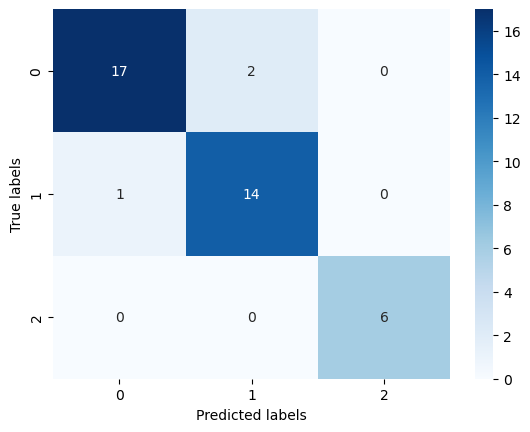

In [331]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.savefig('confusion_matrix.png', dpi=300)  
plt.show()